# Num-pyro example
from https://num.pyro.ai/en/stable/examples/bnn.html

In [2]:
import torch
from torch import nn
import numpy as np
import warnings
import pyro
from pyro import distributions as dist
from pyro.infer import MCMC, NUTS, SVI, Trace_ELBO, Predictive, TraceMeanField_ELBO, JitTraceMeanField_ELBO
from pyro.optim import Adam

import matplotlib.pyplot as plt
import seaborn as sn

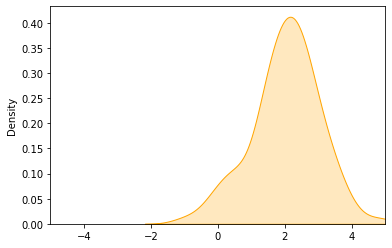

In [87]:
X = np.random.normal(2, 1.0, size=100)
plt.xlim(-5, 5)
sn.distplot(X, color="orange", hist=False, kde = True, kde_kws = {'shade': True, 'linewidth': 1})
plt.show()

Build pyro model:

- similar to stan
- parameters which we want to sample are created by 'pyro.sample(...)'
- the distribution in pyro.sample(...) is the prior

In [88]:
def model(X):
    N = X.shape[0]
    mu = pyro.sample("mu", dist.Normal(0.0, 15.0))
    sigma = pyro.sample("sd", dist.HalfNormal(15.0))
    with pyro.plate("data", N):
        pyro.sample("X", dist.Normal(mu, sigma), obs = X)

### MCMC Sampling:

- specify kernel, here No-U-turn Sampler (change to HMSC if you want); NUTS is also the default in stan
- run and extract samples via 'mcmc.samples(num_samples=N)'

In [89]:
XT = torch.tensor(X, dtype=torch.float32)
pyro.clear_param_store()
mcmc = MCMC( pyro.infer.NUTS(model, jit_compile=False), num_samples=100)
mcmc.run(torch.tensor(X.reshape([-1,1]), dtype=torch.float32))

Sample: 100%|██████████| 200/200 [00:01, 150.09it/s, step size=6.65e-01, acc. prob=0.916]


<AxesSubplot:ylabel='Density'>

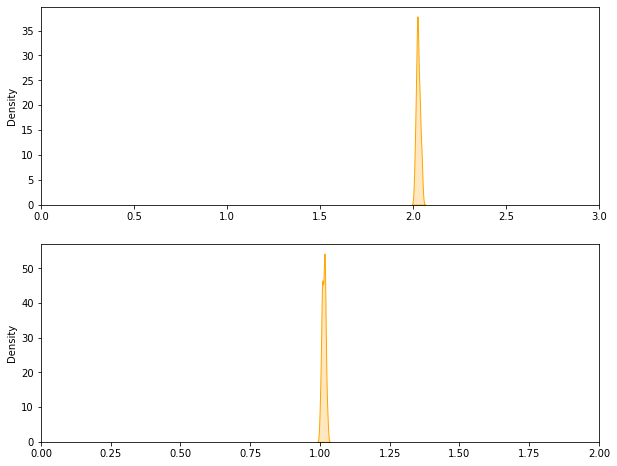

In [90]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.xlim(0, 3)
sn.distplot(mcmc.get_samples()["mu"].data.cpu().numpy(), color="orange", hist=False, kde = True, kde_kws = {'shade': True, 'linewidth': 1})
plt.subplot(2, 1, 2)
plt.xlim(0, 2)
sn.distplot(mcmc.get_samples()["sd"].data.cpu().numpy(), color="orange", hist=False, kde = True, kde_kws = {'shade': True, 'linewidth': 1})

### (Stochastic) Variational Inference with Pyro

The difference to MCMC is that we have to build a 'guide' which specifies the posterior distributions of our parameters. Afterwards, the parameters of the posterior distribution are optimized via stochastic gradient descent (the pyro.plate(...) tells the model that the data dimension is independent)

In [99]:
XT = torch.tensor(X, dtype=torch.float32)
pyro.clear_param_store()
def model(X):
    N = X.shape[0]
    mu = pyro.sample("mu", dist.Normal(0.0, 15.0))
    sigma = pyro.sample("sigma", dist.HalfNormal(15.0))
    with pyro.plate("data", N):
        pyro.sample("X", dist.Normal(mu, sigma), obs = X)
def posterior(X):
    mu_q = pyro.param("mu_q", torch.zeros(1))
    sd_q = pyro.param("sd_q", torch.ones(1), constraint=dist.constraints.positive)
    pyro.sample("mu", dist.Normal(mu_q, sd_q))
    sigma_q = pyro.param("sd_q", torch.ones(1), constraint=dist.constraints.positive)
    pyro.sample("sigma", dist.HalfNormal(sigma_q))

adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)
svi = SVI(model, posterior, optimizer, loss= TraceMeanField_ELBO())

for step in range(5000):
    loss = svi.step(XT)
    if step % 1000 == 0:
        print('[iter {}]  loss: {:.4f}'.format(step, loss))
    

[iter 0]  loss: 163.8184
[iter 1000]  loss: 1429.2905
[iter 2000]  loss: 1046.0272
[iter 3000]  loss: 1086.0327
[iter 4000]  loss: 328.8210


<AxesSubplot:ylabel='Density'>

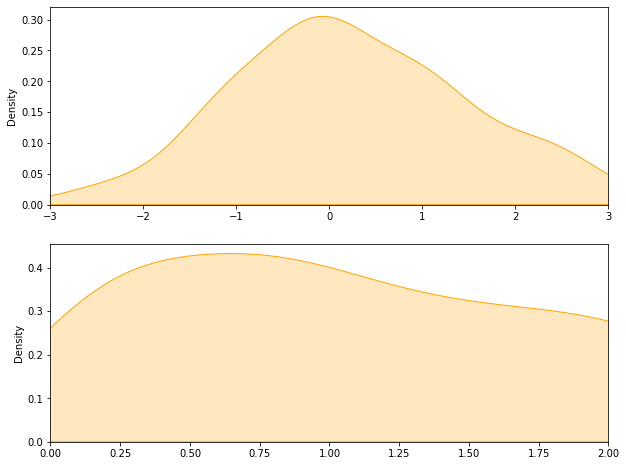

In [103]:
predictive = pyro.infer.Predictive(model, guide=posterior, num_samples=200)(XT)
warnings.filterwarnings('ignore')
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.xlim(-3, 3)
sn.distplot(predictive["mu"].squeeze().data.cpu().numpy(), color="orange", hist=False, kde = True, kde_kws = {'shade': True, 'linewidth': 1})
plt.subplot(2, 1, 2)
plt.xlim(0, 2)
sn.distplot(predictive["sigma"].squeeze().data.cpu().numpy(), color="orange", hist=False, kde = True, kde_kws = {'shade': True, 'linewidth': 1})

Pyro supports so called AutoGuides which can be used to build automatically the posterior guide for our model:

[iter 0]  loss: 358.5870
[iter 1000]  loss: 259.5180
[iter 2000]  loss: 179.0437
[iter 3000]  loss: 156.1925
[iter 4000]  loss: 153.4200


<AxesSubplot:ylabel='Density'>

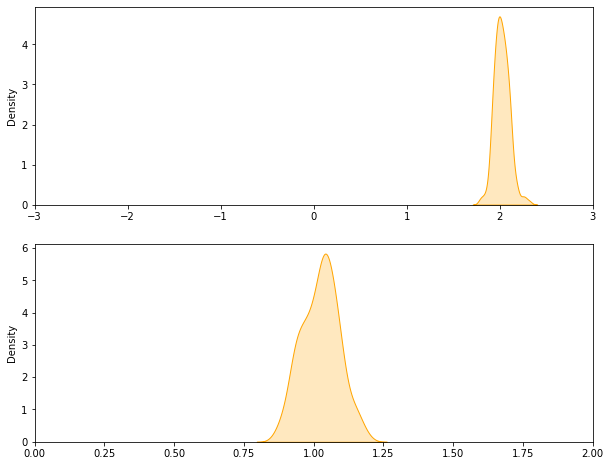

In [104]:
XT = torch.tensor(X, dtype=torch.float32)
pyro.clear_param_store()
def model(X):
    N = X.shape[0]
    mu = pyro.sample("mu", dist.Normal(0.0, 15.0))
    sigma = pyro.sample("sigma", dist.HalfNormal(15.0))
    with pyro.plate("data", N):
        pyro.sample("X", dist.Normal(mu, sigma), obs = X)

adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)
guide = pyro.infer.autoguide.guides.AutoDiagonalNormal(model, init_scale=0.001 )

svi = SVI(model, guide, optimizer, loss= TraceMeanField_ELBO())

for step in range(5000):
    loss = svi.step(XT)
    if step % 1000 == 0:
        print('[iter {}]  loss: {:.4f}'.format(step, loss))
        
predictive = pyro.infer.Predictive(model, guide=guide, num_samples=200)(XT)
warnings.filterwarnings('ignore')
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.xlim(-3, 3)
sn.distplot(predictive["mu"].squeeze().data.cpu().numpy(), color="orange", hist=False, kde = True, kde_kws = {'shade': True, 'linewidth': 1})
plt.subplot(2, 1, 2)
plt.xlim(0, 2)
sn.distplot(predictive["sigma"].squeeze().data.cpu().numpy(), color="orange", hist=False, kde = True, kde_kws = {'shade': True, 'linewidth': 1})